In [1]:
from keras import __version__
import numpy as np
from keras.models import model_from_json, Model, Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from keras import optimizers
from sklearn.model_selection import train_test_split
import keras
from tempfile import TemporaryFile
import csv
from sklearn.neighbors import KDTree, NearestNeighbors
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_model(weights_path, json_path):
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    return loaded_model

def get_clothing_vector_model(weights_path, json_path):
    loaded_model = load_model(weights_path, json_path)
    loaded_model.layers.pop() # Get rid of the classification layer
    last = loaded_model.layers[-1].output
    model = Model(loaded_model.input, last)
    return model

def image_preprocess(img_path):
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) however we need to expand the
    # dimension by making the shape (1, inputShape[0], inputShape[1], 3)
    # so we can pass it through thenetwork
    image = np.expand_dims(image, axis=0)

    # pre-process the image using the appropriate function based on the
    # model that has been loaded (i.e., mean subtraction, scaling, etc.)
    image = preprocess_input(image)
    return image

def get_classier_prediction(clothing_classifier, img_path):
    clothes_labels = ['dresses', 'handbags', 'hats', 'jackets', 'jeans', 
                      'jewelry', 'shorts', 'skirts', 'sunglasses', 'sweaters', 
                      'sweatshirts', 'womens-outerwear', 'womens-pants', 'womens-shoes', 'womens-tops']
    img = image_preprocess(img_path)
    preds = clothing_classifier.predict(img)[0]
    preds_labels = list(zip(clothes_labels, preds))
    preds_labels.sort(key=lambda p: p[1], reverse=True)
    return preds_labels

In [3]:
clothing_classifier_weights_path = 'model_files/inceptionv3_clothing_expanded_classifier.h5'
clothing_classifier_json_path = 'model_files/incep_filter_clothing_expanded_classifier.json'
clothing_classifier = load_model(clothing_classifier_weights_path, clothing_classifier_json_path)
clothing_classifier.summary()

Loaded model from disk
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_234 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_233 (BatchNo (None, None, None, 32 96          conv2d_234[0][0]                 
____________________________________________________________________________________________________
activation_233 (Activation)      (None, None, None, 32 0           batch_normalization_233[0][0]    
____________________________________________________________________

In [4]:
jeans_img_path = 'data-all/validation/jeans/482888849.jpg'
dress_img_path = 'data-all/validation/dresses/535993294.jpg'
jackets_img_path = 'data-all/validation/jackets/614521319.jpg'
jackets_img_path2 = 'data-all/validation/jackets/614763686.jpg'
sunglasses_img_path = 'data-all/validation/sunglasses/655241570.jpg'
dog_img_path = 'data-pets/train/dogs/dog.0.jpg'
get_classier_prediction(clothing_classifier, jeans_img_path)

[('jeans', 0.9994086),
 ('womens-pants', 0.00057120068),
 ('skirts', 9.8396049e-06),
 ('shorts', 5.1550901e-06),
 ('womens-shoes', 1.5977403e-06),
 ('dresses', 1.3391239e-06),
 ('sunglasses', 1.1239362e-06),
 ('handbags', 4.7019142e-07),
 ('womens-tops', 2.4409965e-07),
 ('jackets', 1.8252952e-07),
 ('sweaters', 1.2994336e-07),
 ('womens-outerwear', 1.1318394e-07),
 ('sweatshirts', 6.9145734e-08),
 ('jewelry', 2.7152957e-08),
 ('hats', 1.3843318e-08)]

In [5]:
classifier_vector_model = get_clothing_vector_model(clothing_classifier_weights_path, clothing_classifier_json_path)
img_jacket = image_preprocess(jackets_img_path)
img_jacket2 = image_preprocess(jackets_img_path2)
img_jeans = image_preprocess(jeans_img_path)
img_dress = image_preprocess(dress_img_path)
img_dog = image_preprocess(dog_img_path)

jacket_feat = classifier_vector_model.predict(img_jacket)
jacket_feat2 = classifier_vector_model.predict(img_jacket2)
jeans_feat = classifier_vector_model.predict(img_jeans)
dress_feat = classifier_vector_model.predict(img_dress)
dog_feat = classifier_vector_model.predict(img_dog)

jacket_feat

Loaded model from disk


array([[ 0.4811013 ,  1.57449007,  0.03476681, ...,  1.22023487,
         0.35871759,  0.71462518]], dtype=float32)

In [6]:
# compare cosine similarities
print('2 jackets: ', cosine_similarity(jacket_feat, jacket_feat2))
print('jeans and dress: ', cosine_similarity(jeans_feat, dress_feat))
print('jeans and dog: ', cosine_similarity(jeans_feat, dog_feat))

2 jackets:  [[ 0.97938693]]
jeans and dress:  [[ 0.97675443]]
jeans and dog:  [[ 0.98362172]]


In [7]:
jacket_feat.shape # (1, 1024)

(1, 1024)

## Skipgrams Model

In [53]:
def save_product_features(model, product_file, img_dir, output_file):
    products = []
    print('Reading file ', product_file)
    with open(product_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:]):
            if i % 50 == 0:
                print('Processing product ', i)
            try:
                l = line.split('\t')
                product_id = l[0]
                product_img_path = img_dir + product_id + '.jpg' 
                product_img = image_preprocess(product_img_path)
                product_feat = model.predict(product_img)
    
                products.append([product_id] + product_feat[0].tolist())
            except Exception as e:
                print(e)
                
    print('Saving products to ', output_file)
    with open(output_file, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        for p in products:
            writer.writerow(p)
            f.flush()
    return products

def make_product_X_y(product_to_features, product1_id, product2_id, product3_id):
    product1_feat = product_to_features[product1_id]
    product2_feat = product_to_features[product2_id]
    product3_feat = product_to_features[product3_id]

    merged_feat = np.concatenate((product1_feat, product2_feat), axis=1)
    return merged_feat, product3_feat
    
    
def make_product_permutation_generator(outfit_permutations_file, product_to_features, batch_size):
    while True:
        with open(outfit_permutations_file, 'r') as f:
            curr_batch_X = []
            curr_batch_y = []
            for line in f:
                if len(curr_batch_X) == batch_size:
                    curr_batch_X = []
                    curr_batch_y = []
                    
                l = line.split()
                product1_id = l[2]
                product2_id = l[5]
                product3_id = l[8]
                merged_feat, y_feat = make_product_X_y(product_to_features, product1_id, product2_id, 
                                                       product3_id)
                curr_batch_X.append(merged_feat)
                curr_batch_y.append(y_feat)
                if len(curr_batch_X) == batch_size:
                    yield (np.array(curr_batch_X), np.array(curr_batch_y))


def get_product_to_features(product_feats_file):
    product_to_feats = {}
    rf_feature_import_file = 'rf_feat_import.dat'
    all_feat_importances = np.load(rf_feature_import_file)
    top_features = sorted(list(zip(range(0, 1024), all_feat_importances)), key=lambda tup: tup[1], reverse=True)
    bottom_feature_indexes = [f[0] for f in top_features[150:]]
    with open(product_feats_file, 'r') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        for row in tsvreader:
            product_id = row[0]
            feats_stored = [float(n) for n in row[1:]]
            feats_reduced = np.delete(feats_stored, bottom_feature_indexes)
            feats = np.array([feats_reduced])
            product_to_feats[product_id] = feats
    return product_to_feats


def save_product_features(product_file, product_to_features):
    """for TSNE"""
    output_features_file = 'product_features_tsne.tsv'
    output_labels_file = 'product_names_tsne.tsv'
    f_features = open(output_features_file, 'w')
    writer_features = csv.writer(f_features, delimiter='\t')
    
    f_labels = open(output_labels_file, 'w')
    writer_labels = csv.writer(f_labels, delimiter='\t')
    print('Reading file ', product_file)
    with open(product_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:]):
            if i % 1000 == 0:
                print('Processing product ', i)
            try:
                l = line.split('\t')
                product_id = l[0]
                features = product_to_features[product_id]
                writer_features.writerow(features[0])
                f_features.flush()
            
                product_name = l[3]
                product_category = l[2]
                writer_labels.writerow([product_name.strip(), product_category])
                f_labels.flush()
            
            except Exception as e:
                print(e)
    

In [9]:
# Run one time to save product weights
# save_product_features(classifier_vector_model, 'data-outfits/outfit_products_small.tsv', 
#                       'data-outfits/images_small/', 'data-outfits/outfit_product_features_small.tsv')

In [10]:
product_feats_file = 'data-outfits/outfit_product_features_small.tsv'
outfit_permutations_file = 'data-outfits/outfit_permutations_small.tsv'
prods_to_feats = get_product_to_features(product_feats_file)

In [52]:
save_product_features('data-outfits/outfit_products_small.tsv', prods_to_feats)

Reading file  data-outfits/outfit_products_small.tsv
Processing product  0
Processing product  1000
Processing product  2000
Processing product  3000
Processing product  4000
Processing product  5000
Processing product  6000
Processing product  7000
Processing product  8000
Processing product  9000
Processing product  10000
Processing product  11000
Processing product  12000
Processing product  13000
Processing product  14000
Processing product  15000
Processing product  16000
Processing product  17000
Processing product  18000


In [45]:
len(prods_to_feats['641336745'][0])

150

In [12]:
# np.array(X).shape # (400, 1, 2048)

In [13]:
def make_skipgrams_clothing_model():
    seq = Sequential()
    seq.add(Dense(300, input_shape=(1,300), activation='relu', name='fc1'))
    seq.add(Dropout(0.2))
    seq.add(Dense(128, activation='relu', name='fc2'))
    seq.add(Dropout(0.2))
    seq.add(Dense(150, activation='linear', name='fc_final'))
    #seq.compile(loss="mean_squared_error", optimizer=optimizers.RMSprop(lr=0.00001), metrics=['mae'])
    seq.compile(loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.001), metrics=['mae'])
    return seq

Epoch 1/150
97/97 [==============================] - 3s - loss: 0.9974 - mean_absolute_error: 0.7313 - val_loss: 0.8068 - val_mean_absolute_error: 0.6307
Epoch 2/150
97/97 [==============================] - 2s - loss: 0.8668 - mean_absolute_error: 0.6696 - val_loss: 0.7408 - val_mean_absolute_error: 0.5928
Epoch 3/150
97/97 [==============================] - 2s - loss: 0.8042 - mean_absolute_error: 0.6370 - val_loss: 0.7062 - val_mean_absolute_error: 0.5715
Epoch 4/150
97/97 [==============================] - 2s - loss: 0.7673 - mean_absolute_error: 0.6167 - val_loss: 0.6842 - val_mean_absolute_error: 0.5577
Epoch 5/150
97/97 [==============================] - 2s - loss: 0.7417 - mean_absolute_error: 0.6024 - val_loss: 0.6679 - val_mean_absolute_error: 0.5476
Epoch 6/150
97/97 [==============================] - 2s - loss: 0.7224 - mean_absolute_error: 0.5916 - val_loss: 0.6548 - val_mean_absolute_error: 0.5395
Epoch 7/150
97/97 [==============================] - 2s - loss: 0.7067 - mea

97/97 [==============================] - 2s - loss: 0.5804 - mean_absolute_error: 0.5215 - val_loss: 0.5221 - val_mean_absolute_error: 0.4687
Epoch 22/150
97/97 [==============================] - 2s - loss: 0.5733 - mean_absolute_error: 0.5183 - val_loss: 0.5148 - val_mean_absolute_error: 0.4650
Epoch 23/150
97/97 [==============================] - 2s - loss: 0.5667 - mean_absolute_error: 0.5154 - val_loss: 0.5076 - val_mean_absolute_error: 0.4614
Epoch 24/150
97/97 [==============================] - 2s - loss: 0.5601 - mean_absolute_error: 0.5125 - val_loss: 0.5007 - val_mean_absolute_error: 0.4580
Epoch 25/150
97/97 [==============================] - 2s - loss: 0.5537 - mean_absolute_error: 0.5096 - val_loss: 0.4940 - val_mean_absolute_error: 0.4547
Epoch 26/150
97/97 [==============================] - 2s - loss: 0.5474 - mean_absolute_error: 0.5068 - val_loss: 0.4874 - val_mean_absolute_error: 0.4515
Epoch 27/150
97/97 [==============================] - 2s - loss: 0.5415 - mean_abso

97/97 [==============================] - 2s - loss: 0.4682 - mean_absolute_error: 0.4704 - val_loss: 0.4085 - val_mean_absolute_error: 0.4140
Epoch 43/150
97/97 [==============================] - 2s - loss: 0.4639 - mean_absolute_error: 0.4685 - val_loss: 0.4048 - val_mean_absolute_error: 0.4123
Epoch 44/150
97/97 [==============================] - 2s - loss: 0.4598 - mean_absolute_error: 0.4665 - val_loss: 0.4010 - val_mean_absolute_error: 0.4107
Epoch 45/150
97/97 [==============================] - 2s - loss: 0.4560 - mean_absolute_error: 0.4647 - val_loss: 0.3974 - val_mean_absolute_error: 0.4091
Epoch 46/150
97/97 [==============================] - 2s - loss: 0.4525 - mean_absolute_error: 0.4631 - val_loss: 0.3939 - val_mean_absolute_error: 0.4075
Epoch 47/150
97/97 [==============================] - 2s - loss: 0.4487 - mean_absolute_error: 0.4613 - val_loss: 0.3904 - val_mean_absolute_error: 0.4060
Epoch 48/150
97/97 [==============================] - 2s - loss: 0.4448 - mean_abso

97/97 [==============================] - 2s - loss: 0.3954 - mean_absolute_error: 0.4363 - val_loss: 0.3420 - val_mean_absolute_error: 0.3859
Epoch 64/150
97/97 [==============================] - 2s - loss: 0.3925 - mean_absolute_error: 0.4351 - val_loss: 0.3393 - val_mean_absolute_error: 0.3848
Epoch 65/150
97/97 [==============================] - 2s - loss: 0.3895 - mean_absolute_error: 0.4336 - val_loss: 0.3366 - val_mean_absolute_error: 0.3838
Epoch 66/150
97/97 [==============================] - 2s - loss: 0.3865 - mean_absolute_error: 0.4322 - val_loss: 0.3340 - val_mean_absolute_error: 0.3827
Epoch 67/150
97/97 [==============================] - 2s - loss: 0.3840 - mean_absolute_error: 0.4309 - val_loss: 0.3314 - val_mean_absolute_error: 0.3817
Epoch 68/150
97/97 [==============================] - 2s - loss: 0.3807 - mean_absolute_error: 0.4296 - val_loss: 0.3288 - val_mean_absolute_error: 0.3807
Epoch 69/150
97/97 [==============================] - 2s - loss: 0.3782 - mean_abso

97/97 [==============================] - 2s - loss: 0.3417 - mean_absolute_error: 0.4118 - val_loss: 0.2929 - val_mean_absolute_error: 0.3669
Epoch 85/150
97/97 [==============================] - 2s - loss: 0.3391 - mean_absolute_error: 0.4105 - val_loss: 0.2910 - val_mean_absolute_error: 0.3662
Epoch 86/150
97/97 [==============================] - 2s - loss: 0.3373 - mean_absolute_error: 0.4096 - val_loss: 0.2892 - val_mean_absolute_error: 0.3655
Epoch 87/150
97/97 [==============================] - 2s - loss: 0.3353 - mean_absolute_error: 0.4088 - val_loss: 0.2873 - val_mean_absolute_error: 0.3648
Epoch 88/150
97/97 [==============================] - 2s - loss: 0.3334 - mean_absolute_error: 0.4080 - val_loss: 0.2856 - val_mean_absolute_error: 0.3641
Epoch 89/150
97/97 [==============================] - 2s - loss: 0.3315 - mean_absolute_error: 0.4069 - val_loss: 0.2838 - val_mean_absolute_error: 0.3635
Epoch 90/150
97/97 [==============================] - 2s - loss: 0.3297 - mean_abso

97/97 [==============================] - 2s - loss: 0.3066 - mean_absolute_error: 0.3953 - val_loss: 0.2614 - val_mean_absolute_error: 0.3554
Epoch 106/150
97/97 [==============================] - 2s - loss: 0.3051 - mean_absolute_error: 0.3946 - val_loss: 0.2603 - val_mean_absolute_error: 0.3550
Epoch 107/150
97/97 [==============================] - 2s - loss: 0.3038 - mean_absolute_error: 0.3942 - val_loss: 0.2593 - val_mean_absolute_error: 0.3546
Epoch 108/150
97/97 [==============================] - 2s - loss: 0.3030 - mean_absolute_error: 0.3936 - val_loss: 0.2583 - val_mean_absolute_error: 0.3542
Epoch 109/150
97/97 [==============================] - 2s - loss: 0.3021 - mean_absolute_error: 0.3933 - val_loss: 0.2573 - val_mean_absolute_error: 0.3539
Epoch 110/150
97/97 [==============================] - 2s - loss: 0.3009 - mean_absolute_error: 0.3926 - val_loss: 0.2564 - val_mean_absolute_error: 0.3535
Epoch 111/150
97/97 [==============================] - 2s - loss: 0.2997 - mea

97/97 [==============================] - 2s - loss: 0.2873 - mean_absolute_error: 0.3857 - val_loss: 0.2448 - val_mean_absolute_error: 0.3494
Epoch 127/150
97/97 [==============================] - 2s - loss: 0.2868 - mean_absolute_error: 0.3854 - val_loss: 0.2443 - val_mean_absolute_error: 0.3492
Epoch 128/150
97/97 [==============================] - 2s - loss: 0.2857 - mean_absolute_error: 0.3849 - val_loss: 0.2437 - val_mean_absolute_error: 0.3490
Epoch 129/150
97/97 [==============================] - 2s - loss: 0.2851 - mean_absolute_error: 0.3846 - val_loss: 0.2432 - val_mean_absolute_error: 0.3488
Epoch 130/150
97/97 [==============================] - 2s - loss: 0.2845 - mean_absolute_error: 0.3842 - val_loss: 0.2428 - val_mean_absolute_error: 0.3486
Epoch 131/150
97/97 [==============================] - 2s - loss: 0.2841 - mean_absolute_error: 0.3840 - val_loss: 0.2423 - val_mean_absolute_error: 0.3485
Epoch 132/150
97/97 [==============================] - 2s - loss: 0.2835 - mea

97/97 [==============================] - 2s - loss: 0.2763 - mean_absolute_error: 0.3794 - val_loss: 0.2365 - val_mean_absolute_error: 0.3461
Epoch 148/150
97/97 [==============================] - 2s - loss: 0.2759 - mean_absolute_error: 0.3793 - val_loss: 0.2362 - val_mean_absolute_error: 0.3460
Epoch 149/150
97/97 [==============================] - 2s - loss: 0.2758 - mean_absolute_error: 0.3791 - val_loss: 0.2359 - val_mean_absolute_error: 0.3459
Epoch 150/150
97/97 [==============================] - 2s - loss: 0.2754 - mean_absolute_error: 0.3788 - val_loss: 0.2357 - val_mean_absolute_error: 0.3457
Saving skipgrams models
dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


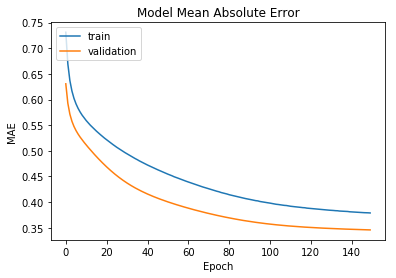

In [14]:
def fit_save_skipgram_clothing_model(weights_file, json_file):
    batch_size = 1024
    nb_train_samples = 100000
    nb_val_samples = 28800
    epochs = 150
    model = make_skipgrams_clothing_model()
    train_outfit_permutations_file = 'data-outfits/outfit_permutations_small_train.tsv'
    val_outfit_permutations_file = 'data-outfits/outfit_permutations_small_val.tsv'
    train_generator = make_product_permutation_generator(train_outfit_permutations_file, 
                                                         prods_to_feats, batch_size)
    validation_generator = make_product_permutation_generator(val_outfit_permutations_file, 
                                                         prods_to_feats, batch_size)
    checkpoint = ModelCheckpoint(weights_file, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    history = model.fit_generator(generator=train_generator, 
                                  validation_data=validation_generator,
                                  epochs=epochs, 
                                  steps_per_epoch=nb_train_samples//batch_size,
                                  validation_steps=nb_val_samples//batch_size,
                                  callbacks = [checkpoint])
    print('Saving skipgrams models')
    model.save(weights_file)
    model_json = model.to_json()
    with open(json_file, 'w') as json_file:
        json_file.write(model_json)
    
    print(history.history.keys())
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    return model

skipgram_model_weights_file = 'model_files/outfit_skipgram_model_small_weights.h5'
skipgram_model_json_file = 'model_files/outfit_skipgram_model_small.json'
model_fit_history = fit_save_skipgram_clothing_model(skipgram_model_weights_file, skipgram_model_json_file)

In [15]:
# 1st epoch: loss: mean_absolute_error: 1.5737 - val_loss: 3.0892 - val_mean_absolute_error: 1.0031 
# 70th epoch: loss: 1.7930 - mean_absolute_error: 0.7442 - val_loss: 1.6994 - val_mean_absolute_error: 0.6589 
clothing_skipgrams_model = load_model(skipgram_model_weights_file, skipgram_model_json_file)

Loaded model from disk


In [16]:
merged_feat_test, y_feat_actual = make_product_X_y(prods_to_feats, '625092040', '647750111', '536961691')
# Predicted Output
clothing_skipgrams_model.predict(np.array([merged_feat_test]))

array([[[ 0.2491221 ,  0.32235801,  0.14007691,  0.22644553,  0.30397946,
          0.30986637,  0.22831659,  0.60678351,  0.10506044,  0.07269388,
          0.12641662,  1.12404096,  0.23913528,  0.46370131,  0.41052774,
          0.22588301,  0.06856789,  0.26488781,  0.33244911,  0.09563206,
          0.23263578,  1.73100936,  0.43803051,  0.16012995,  0.43350694,
          0.16406384,  0.17953591,  0.04402016,  0.15047976,  0.1868034 ,
          0.13503025,  0.36560562,  0.21119681,  0.55281603,  0.13286026,
          0.20738758,  0.0369515 ,  0.12721935,  0.36541599,  0.28168213,
          0.10533956,  0.18767112,  0.20619956,  0.66473609,  0.28413063,
          0.35583517,  0.3727389 ,  0.33900332,  0.21818919,  0.25526905,
          0.51972067,  0.5291    ,  0.22526993,  0.16966736,  0.18192396,
          0.02919805,  0.25960156,  0.30392796,  0.13878317,  0.12002466,
          0.04338362,  0.16866927,  0.32062763,  0.33131996,  0.33394659,
          0.11362264,  0.22655647,  0.

In [25]:
def display_images(image_paths):
    image_count = len(image_paths)
    fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
    
    for i, image_file in enumerate(image_paths):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        ax[i].imshow(image, interpolation='nearest')
        ax[i].axis("off")
    plt.show()

def display_product_images(product_ids):
    image_files = ['data-outfits/images_small/' + product_id + '.jpg' for product_id in product_ids]
    display_images(image_files)

    
def get_prod_feat_list():
    index_to_prod = {}
    prod_features = []
    for i, prod_feat in enumerate(prods_to_feats.items()):
        prod_id, feat = prod_feat
        index_to_prod[i] = prod_id
        prod_features.append(feat[0])
    return index_to_prod, np.array(prod_features)

index_to_prod, prod_features = get_prod_feat_list()
print('Making Nearest Neighbors ...')
#neighbors_model = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')
neighbors_model = NearestNeighbors(n_neighbors=20, metric='l2', algorithm='auto')
neighbors_model.fit(prod_features)

Making Nearest Neighbors ...


NearestNeighbors(algorithm='auto', leaf_size=30, metric='l2',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)

In [18]:
neighbors_model.kneighbors(prod_features[:3], 5, return_distance=False)

array([[    0,  2162,  9839, 14405,  9344],
       [    1, 14114, 15861,  1046, 16710],
       [    2, 15805,  9412,  2091,  9371]])

In [19]:
def get_closest_product_ids(input_features, model, index_to_prod_mapping):
    product_indexes = model.kneighbors(input_features, 15, return_distance=False)
    return [index_to_prod_mapping[index] for index in product_indexes[0]]

Input & Output Products: ['625092040', '647750111', '536961691']


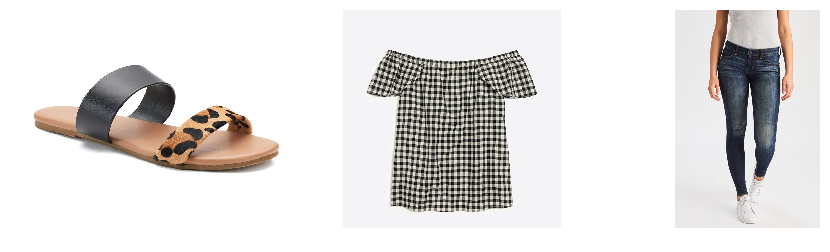

Closest products: ['641492451', '632811357', '648341963', '649806057', '613376563', '504284654', '532889741', '622271213', '631337402', '632592402', '651696913', '665886653', '505925786', '629703371', '639133423']


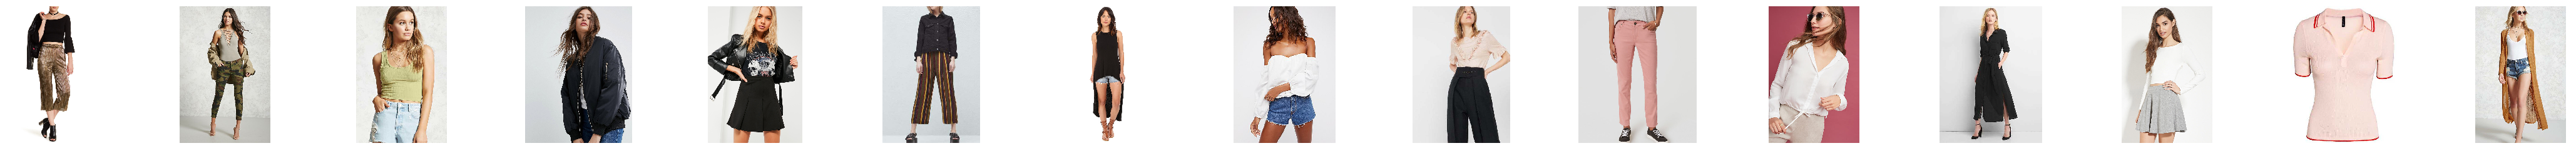

Input & Output Products: ['635920212', '635920206', '639439302']


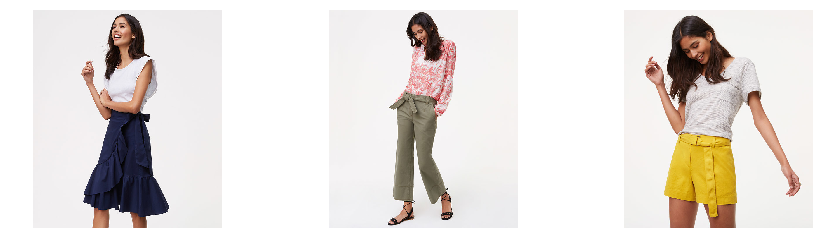

Closest products: ['532035063', '646593150', '643468977', '637784203', '472037552', '629050422', '519722686', '640532595', '622958530', '604164211', '626625713', '419595282', '623238934', '639532432', '501295147']


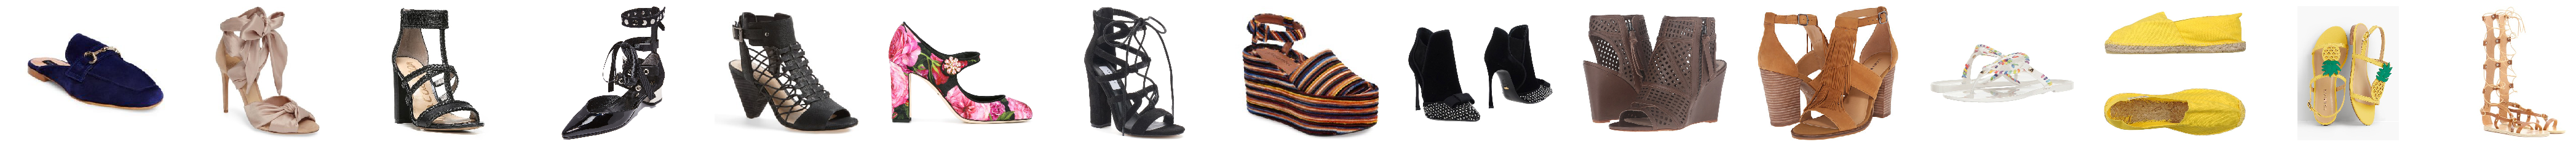

Input & Output Products: ['488003929', '620959414', '607186212']


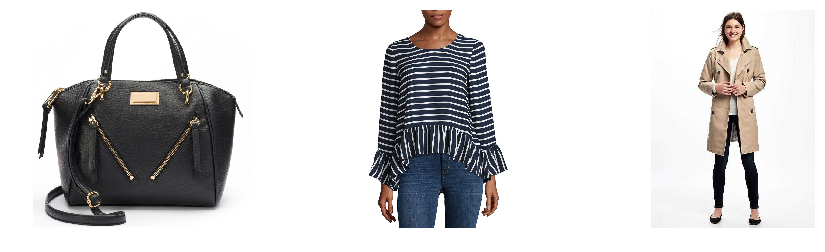

Closest products: ['610840671', '621173819', '613376563', '476592629', '640650311', '648341963', '543800007', '456480758', '638675298', '651696913', '646234593', '538500580', '641842260', '655944083', '633871303']


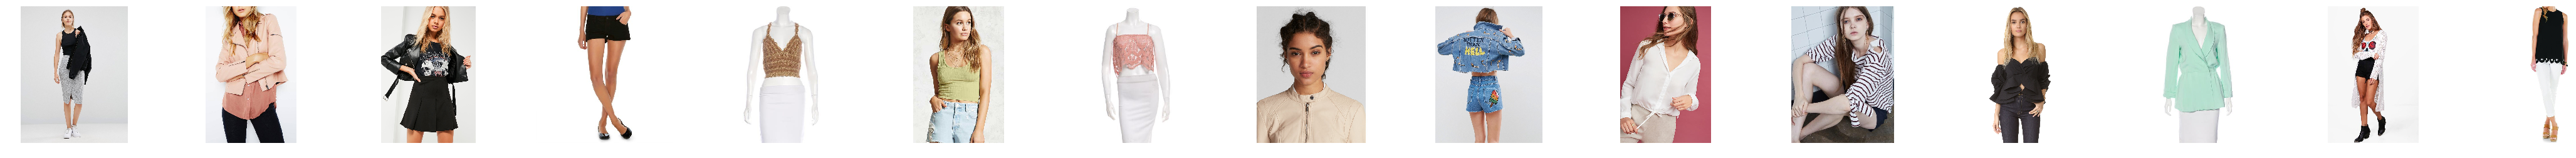

Input & Output Products: ['528995828', '494801318', '608796826']


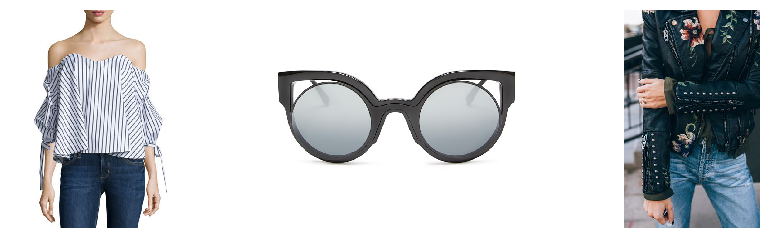

Closest products: ['644008138', '660223507', '604164211', '647428554', '508060549', '646593150', '629050422', '652117491', '643468977', '628463312', '636573903', '649323932', '659197030', '437324262', '515747604']


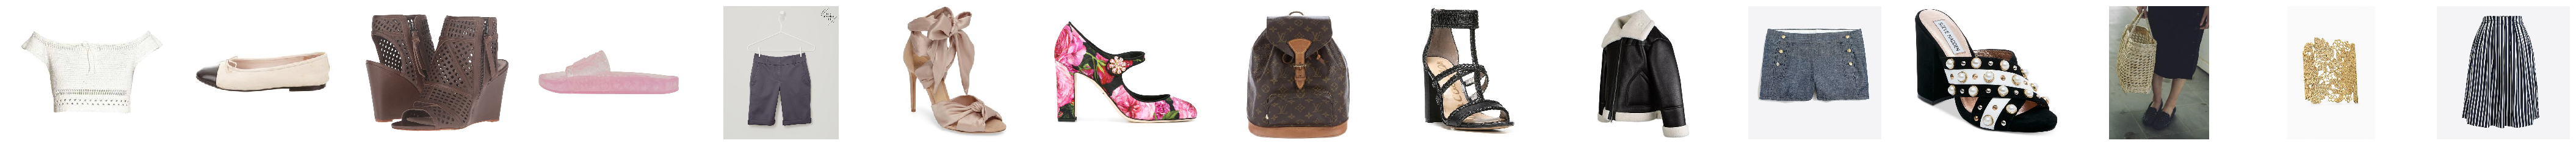

Input & Output Products: ['639532406', '537516964', '633390330']


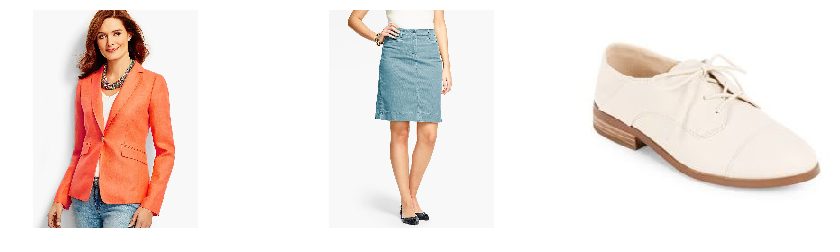

Closest products: ['629050422', '646593150', '643468977', '604164211', '660223507', '647428554', '513532923', '532035063', '644008138', '640532595', '629139203', '649323932', '652117491', '501295147', '648337781']


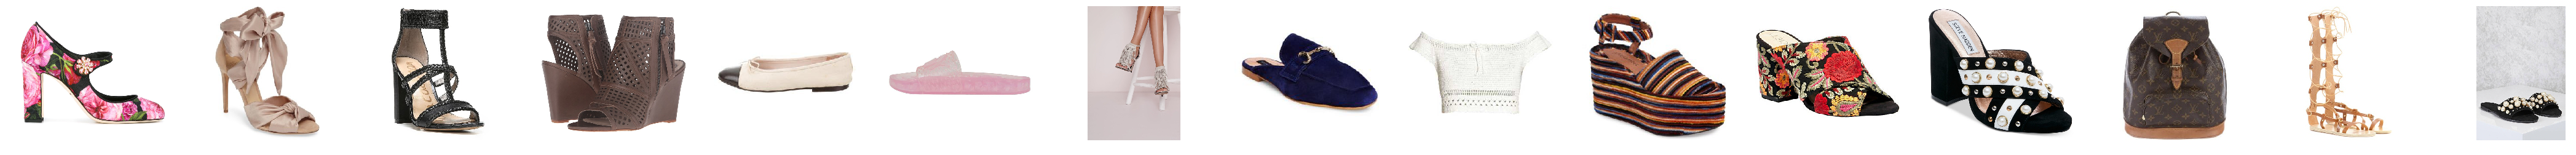

In [26]:
def test_predictions():
    test_file = 'data-outfits/outfit_permutations_small_sample.tsv'
    with open(test_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:5]):
            l = line.split()
            product1_id = l[2]
            product2_id = l[5]
            product3_id = l[8]
            product_ids = [product1_id, product2_id, product3_id]
            merged_feat, y_feat = make_product_X_y(prods_to_feats, product1_id, product2_id, 
                                                   product3_id)
                        
            print('Input & Output Products: {}'.format(product_ids))
            display_product_images(product_ids)
            prediction_vector = clothing_skipgrams_model.predict(np.array([merged_feat]))
            prediction_vector = prediction_vector[0]
            # print(prediction_vector)
            closest_product_ids = get_closest_product_ids(prediction_vector, neighbors_model, index_to_prod)
            
            print('Closest products: {}'.format(closest_product_ids))
            display_product_images(closest_product_ids)
            
test_predictions()

In [21]:
a = np.array([[1,2, 3]])
b = np.array([[4,5, 6]])
ab = np.concatenate((a, b, a), axis=1)

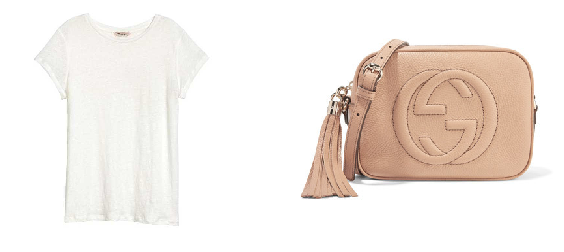

In [22]:
white_shirt_id = '633073622'
pink_bag_id = '645667402'
display_product_images([white_shirt_id, pink_bag_id])

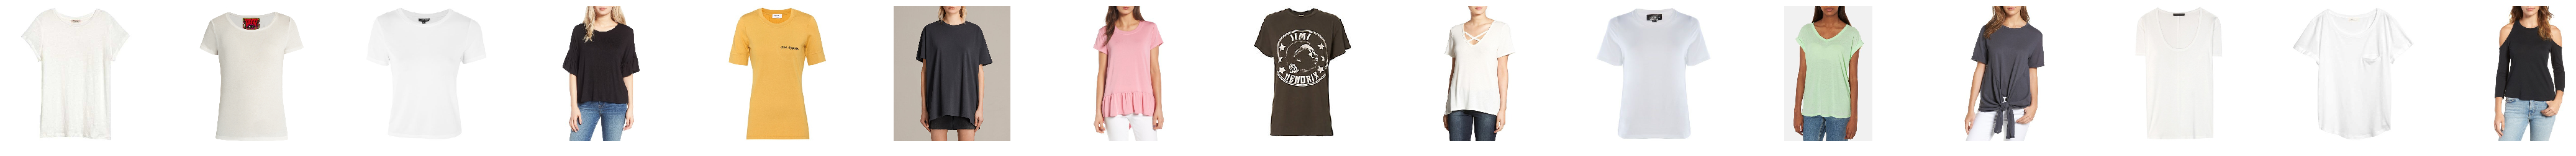

In [23]:
white_shirt_vector = prods_to_feats[white_shirt_id]
closest_white_shirt_ids = get_closest_product_ids(white_shirt_vector, neighbors_model, index_to_prod)
display_product_images(closest_white_shirt_ids)

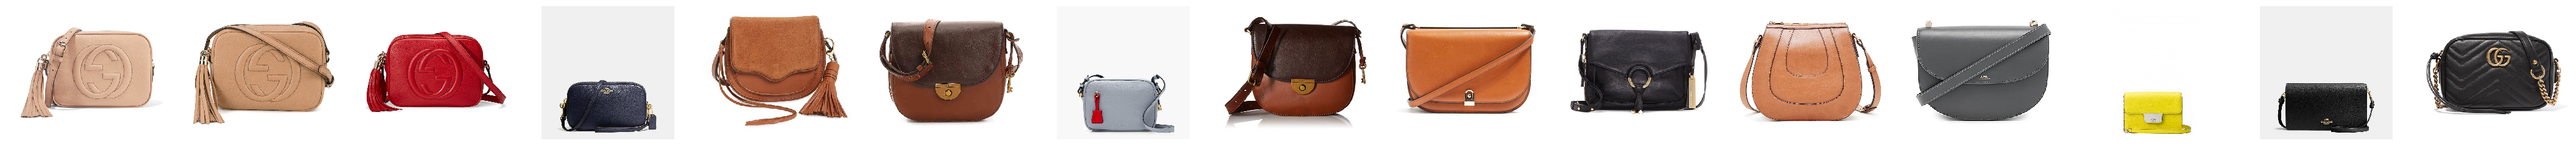

In [24]:
pink_bag_vector = prods_to_feats[pink_bag_id]
closest_pink_bag_ids = get_closest_product_ids(pink_bag_vector, neighbors_model, index_to_prod)
display_product_images(closest_pink_bag_ids)

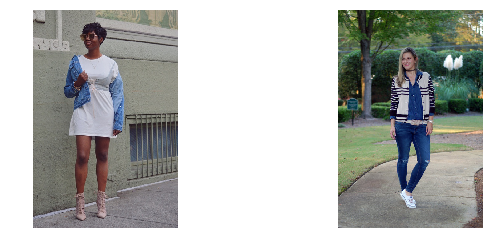

In [34]:
collection_ids = ['42911776', ' ']
collection_paths = ['data-outfits/images_collections/' + cid + '.jpg' for cid in collection_ids]
display_images(collection_paths)

In [33]:
get_classier_prediction(clothing_classifier, collection_paths[1])

[('womens-tops', 0.50720197),
 ('sweaters', 0.39669749),
 ('jeans', 0.045503441),
 ('sweatshirts', 0.044476151),
 ('jackets', 0.0041801385),
 ('womens-pants', 0.00057787797),
 ('handbags', 0.00056184048),
 ('womens-outerwear', 0.000460468),
 ('hats', 0.00025544962),
 ('skirts', 3.2275955e-05),
 ('shorts', 2.5997455e-05),
 ('womens-shoes', 1.1064767e-05),
 ('sunglasses', 8.6473465e-06),
 ('jewelry', 7.0358769e-06),
 ('dresses', 8.2619302e-08)]